# Pursuit curves
Given a target curve $\hat{\mathcal{C}}$ and a positive scalar $q$, a $q$-pursuit curve for $\hat{\mathcal{C}}$ is a curve $\mathcal{C}$ together with a homeomorphism $\pi:\mathcal{C}\mapsto\hat{\mathcal{C}}$ (called the tangential projection) such that
* for any point $P$ of $\mathcal{C}$, the tangent to $\mathcal{C}$ at $P$ contains $\pi(P)$;
* for any points $P_1,P_2$ of $\mathcal{C}$, the length on $\hat{\mathcal{C}}$ of the arc $\pi(P_1),\pi(P_2)$ is $q$ time the length on $\mathcal{C}$ of the arc $P_1,P_2$.

Given:
* a pair $A,\hat{A}$ of reference points
* a scalar $q>0$ and a target curve $\hat{\mathcal{C}}$ containing $\hat{A}$

we seek to determine the $q$-pursuit curves for $\hat{\mathcal{C}}$ which contain $A$ and such that the tangential projection of $A$ onto $\hat{\mathcal{C}}$ be $\hat{A}$.

In [1]:
%pylab notebook
# for external animation (less resource consuming), use appropriate backend, e.g. qt5

import logging
from functools import partial
from ipyshow.util import Setup
from ipyshow.odesimu import System
from ipyshow.odesimu.util import logger_hook

Populating the interactive namespace from numpy and matplotlib


## Simulation
We assume the target curve is given by an arbitrary parametrisation $(X(t),Y(t))$. Parameter $t$ is interpreted as time so that the target curve can be viewed as the trajectory of a point, called the leader. For more generality, we assume that $(X,Y)$ is not given directly but obtained as the solution of a given ODE (dynamics equation):
\begin{equation*}
(\dot{X}(t),\dot{Y}(t)) = F(t,(X(t),Y(t)))
\end{equation*}
Initially (at time $t=0$) we assume that the leader is in $\hat{A}$ with coordinates $(X_o,Y_o)$, hence the initial condition of the ODE is $(X(0),Y(0))=(X_o,Y_o)$.

A $q$-pursuit curve can then also be parametrised by the same time parameter, and be obtained as the trajectory of an other point called the pursuer with coordinates $(x,y)$, initially in $A$ with coordinates $(x_o,y_o)$. The equations of the whole system (leader and pursuer) are therefore:
\begin{equation*}
(\dot{X},\dot{Y}) = F(t,(X,Y))
\hspace{2cm}
q\sqrt{\dot{x}^2+\dot{y}^2} = \sqrt{\dot{X}^2+\dot{Y}^2}
\hspace{2cm}
\begin{array}{|cc|}x-X & \dot{x}\\ y-Y & \dot{y}\end{array}=0
\end{equation*}
with initial conditions
\begin{equation*}
x(0),y(0)=x_o,y_o
\hspace{2cm}
X(0),Y(0)=X_o,Y_o
\end{equation*}
If the target curve is given by the (leader) ODE associated with $F$, then the ODE associated with $F^\bot$ where $F^\bot(t,(X,Y))\triangleq-F(-t,(X,Y))$ describes the same target curve: the trajectory of the leader along that curve is simply reversed. But the resulting pursuit curve, given the same initial conditions, will be different. Indeed, there are two possible $q$-pursuit curves for given $q$, target and pair $A,\hat{A}$, and they correspond to the choice between $F$ and $F^\bot$. These two curves are said to be *dual*.

The program below uses a standard package to numerically solve the pursuer+leader ODE. The state is taken to be the quadruple $x,y,X,Y$ (pursuer: first two components; leader: last two components). Observe that the equation is not in completely explicit form. Indeed, there are two ways to put the pursuer part in explicit form, depending on the sign used in the following expression:
\begin{equation*}
\left(\begin{array}{c}\dot{x}\\\dot{y}\end{array}\right) =
\pm\frac{||F(t,(X,Y))||}{q\sqrt{(x-X)^2+(y-Y)^2}}
\left(\begin{array}{c}x-X\\y-Y\end{array}\right) 
\end{equation*}
corresponding to two situations: the pursuer moves toward the leader (positive sign) or away from the leader (negative sign, the pursuer should be called an escaper in that case!). The solution curve obtained in each case is the dual of that obtained in the other case, and the tangent vectors at $A$ are in the opposite direction.

In [2]:
def norm(x): return sqrt(square(x[0])+square(x[1]))

class Pursuit (System):

  shadowshape = (4,)

  @Setup(
    'q: ratio of leader\'s speed to pursuer\'s speed',
    'tol: threshold on the pursuer-leader distance, below which pursuit is stopped',
    tol=1e-3
  )
  def __init__(self,q,F,tol):
    #If q<0, the simulation operates with |q| but the pursuer ODE is dualised.
    self.q = q
    if q<0: F = (lambda t,pos,F=F: -F(-t,pos))
    self.F = F
    self.tol = tol
    def main(t,state,q=abs(q)):
      v = F(t,state[2:4])
      p = state[2:4]-state[0:2]
      d = norm(p)
      if d<tol: return concatenate((v,v))
      p /= q*d ; p *= norm(v)
      return concatenate((p,v))
    self.main = main

  def display(self,ax,**ka):
    s_pursuer = ax.scatter((),(),color='b',s=50,marker='^',label='pursuer')
    s_leader = ax.scatter((),(),color='g',s=50,marker='v',label='leader')
    p_tail = ax.plot((),(),'b',(),(),'g')
    p_tan, = ax.plot((),(),c='k',ls=':')
    ax.legend(fontsize='x-small',loc='lower right')
    def disp(t,live,tail):
      s_pursuer.set_offsets((live[0:2],))
      s_leader.set_offsets((live[2:4],))
      p_tail[0].set_data(tail[:,0],tail[:,1])
      p_tail[1].set_data(tail[:,2],tail[:,3])
      if norm(live[0:2]-live[2:4])<self.tol:
        for a in s_pursuer, s_leader: a.set_color('r')
      else: p_tan.set_data((live[0],live[2]),(live[1],live[3])); ax.relim(); ax.autoscale_view()
    return super().display(ax,disp,**ka)

  @Setup(
    System.launch,
    taild=10.,hooks=(partial(logger_hook,logger=logging.getLogger()),)
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

### An example: parabolic target
Consider the case where the leader moves with constant horizontal speed $v$ and constant vertical acceleration $g$ with no initial vertical speed. The target curve is therefore a parabola. The ODE of the leader is defined by
\begin{equation*}
F(t,(X,Y)) = (v,g\frac{X}{v})
\hspace{1cm}\textrm{or alternatively}\hspace{1cm}
F(t,(X,Y)) = (v,gt)
\end{equation*}
We assume that reference point $\hat{A}$ (initial position of the leader) is taken as the origin of the reference frame (hence $X_o,Y_o=0$).

In [3]:
class ParabolaPursuit (Pursuit):
  @Setup(
    Pursuit.__init__,
    'v: leader\'s horizontal speed [m.sec^-1]',
    'g: leader\'s vertical acceleration (negative) [m.sec^-2]',
    v=1.,g=-1.
  )
  def __init__(self,v,g,**ka):
    super().__init__(F=(lambda t,pos,r=g/v: array((v,r*pos[0]))),**ka)
    self.v, self.g = v,g
  def display(self,ax,ini,h,**ka):
    x = linspace(-h*ini[0],h*ini[0],100)
    ax.plot(x,self.g*square(x/self.v)/2.,c='g',ls='--')
    return super().display(ax,ini=ini,**ka)
  @staticmethod
  @Setup(
    'x,y: position of the pursuer (leader is in 0,0)',
  )
  def makestate(x,y): return array((x,y,0.,0.))
  @Setup(
    Pursuit.launch,
    'h: displays the parabola on interval h times the x-coordinate of the initial position',
    h=1.
  )
  def launch(self,*a,**ka): return super().launch(*a,**ka)

In [4]:
Setup.display(ParabolaPursuit)

**** ParabolaPursuit.__init__(self, v, g, **ka) ****
    q         : ratio of leader's speed to pursuer's speed []
    tol       (0.001     ): threshold on the pursuer-leader distance, below which pursuit is stopped []
    v         (1.0       ): leader's horizontal speed [m.sec^-1]
    g         (-1.0      ): leader's vertical acceleration (negative) [m.sec^-2]
**** ParabolaPursuit.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (10.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
    h         (1.0       ): displays the parabola on interval h times the x-coordinate of the initial position []
**** ParabolaPursuit.makestate(x, y) ****
    x,y       : position of the pursuer (leader is in 0,0) []

<IPython.core.display.Javascript object>


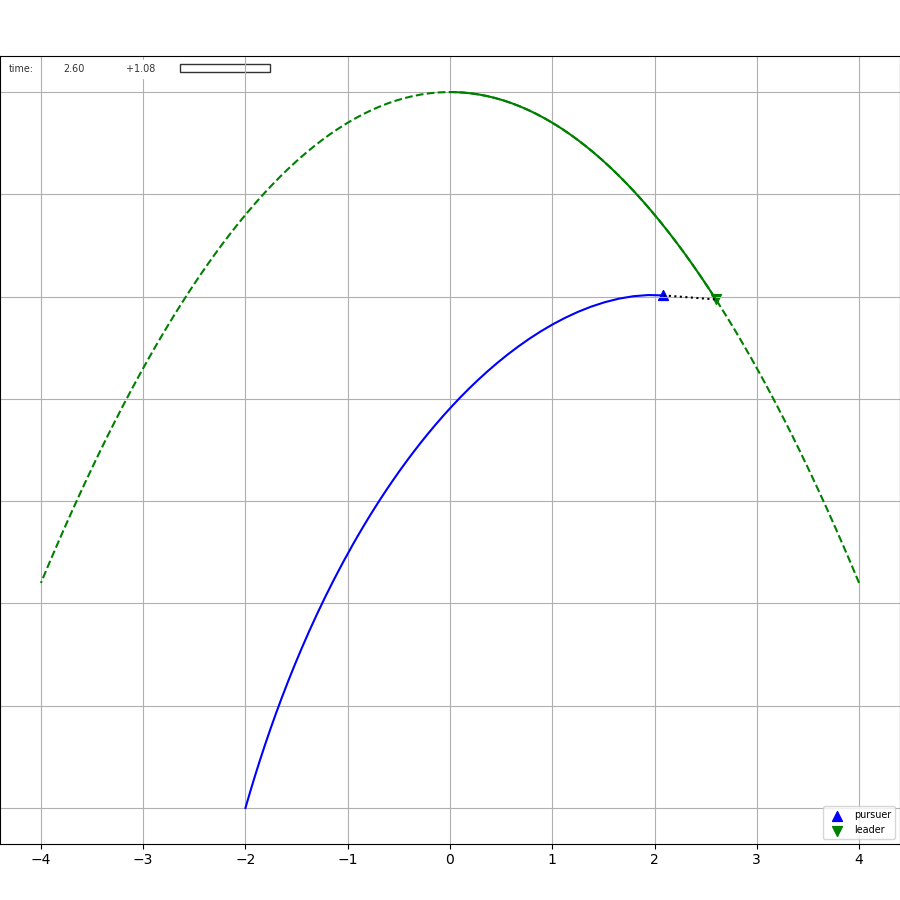

In [7]:
syst = ParabolaPursuit(q=.5,g=-.6); ini = dict(x=-2.,y=-7.)
#syst = ParabolaPursuit(q=-.5,g=-.8); ini = dict(x=-1.,y=-4.)
syst.launch(ini=syst.makestate(**ini),h=2.)

## Analytic solutions
We now assume that the target curve is also given by its natural parametrisation $\hat{x}(s),\hat{y}(s)$, where the parameter $s$ is the arc length (on the target curve) measured from reference point $\hat{A}$. Hence, by construction $\hat{A}$ has coordinates $\hat{x}(0),\hat{y}(0)$ and the equation $\hat{x}'^2+\hat{y}'^2=1$ holds.

Let $x,y$ be some parametrisation of a $q$-pursuit curve, i.e. $x(u),y(u)$ are functions of some parameter $u$. Let $u_o$ be the parameter of the reference point $A$ and $\ell(u)$ be the algebraic length on the pursuit curve of the arc between $A$ and the point of parameter $u$ (given some orientation of the curve). The equations of a $q$-pursuit curve are given by
\begin{equation*}
\ell' = \pm\sqrt{x'^2+y'^2}
\hspace{2cm}
\begin{array}{|cc|}
x-\hat{x}(q\ell) & x'\\
y-\hat{y}(q\ell) & y'
\end{array} = 0
\end{equation*}
with initial conditions
\begin{equation*}
x(u_o) = x_o \hspace{2cm} y(u_o) = y_o \hspace{2cm} \ell(u_o) = 0
\end{equation*}
There are two equations for three unknowns $x,y,\ell$, so the system is under-determined, which is not surprising since there is a degree of freedom in the choice of the parametrisation of the pursuit curve. That choice determines the system, but also the difficulty of its resolution. Also, recall that for a given target curve and pair $A,\hat{A}$ of reference points, there are two dual solution pursuit curves. They correspond to a choice of sign for $\ell'$ in the equations above.

### Analytic solution when the target is a straight line

We assume the origin of the referential frame is taken to be $\hat{A}$ and the vertical axis to be the target curve itself (straight line). The natural parametrisation of the target is hence given by
\begin{equation*}
\hat{x}(s) = 0 \hspace{2cm} \hat{y}(s) = s
\end{equation*}
For the pursuit curve, we assume the parameter is the $x$-coordinate. Hence $x(u)=u$. Furthermore, without loss of generality, we can take $x_o>0$ and $\ell'<0$. The solution is given by
\begin{eqnarray*}
y & = & \frac{1}{2}(\frac{e^c}{1+q}u^{1+q}-\frac{e^{-c}}{1-q}u^{1-q})+y_*
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}-e^{-c}\log(u))+y_*\\
\ell & = & -\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}+\frac{e^{-c}}{1-q}u^{1-q})+\ell_*
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
-\frac{1}{2}(\frac{e^c}{1+q}u^{1+q}+e^{-c}\log(u))+\ell_*
\end{eqnarray*}
Constants $c,y_*,\ell_*$ are given by
\begin{eqnarray*}
e^c & = & x_o^{-q}r \hspace{1cm}\textrm{where}\hspace{1cm} r \triangleq \frac{y_o}{x_o}+\sqrt{1+(\frac{y_o}{x_o})^2}\\
y_* & = & y_o-\frac{x_o}{2}\left(\frac{r}{1+q}-\frac{1}{r(1-q)}\right) 
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
y_o-\frac{x_o}{2}\left(\frac{r}{2}-\frac{\log(x_o)}{r}\right)\\
\ell_* & = & \frac{x_o}{2}\left(\frac{r}{1+q}+\frac{1}{r(1-q)}\right)
\hspace{1cm}\textrm{if $q\not=1$ else}\hspace{1cm}
\frac{x_o}{2}\left(\frac{r}{2}+\frac{\log(x_o)}{r}\right)
\end{eqnarray*}
When $q\not=1$, we have $y_*=q\ell_*$. Furthermore, the critical point of the pursuit curve is given by
\begin{equation*}
x^* = x_or^{-\frac{1}{q}}
\hspace{2cm}
y^* = \frac{x_oq}{2}(\frac{r}{1+q}+\frac{1}{r(1-q)}-\frac{2r^{-\frac{1}{q}}}{1-q^2})
\hspace{.5cm}\textrm{if $q\not=1$ else}\hspace{.5cm}
y_o+\frac{x_o}{2}(\frac{1}{2r}-\frac{r}{2}+\frac{\log(r)}{r})
\end{equation*}
The program below augments the basic simulation by drawing before the start of the simulation a segment of the predicted pursuit curve given by the equations above, together with its remarkable points (critical point, and, when $q<1$, contact point).

In [8]:
class StraightLinePursuit (Pursuit):

  @Setup(
    Pursuit.__init__,
    'v: leader\'s speed [m.sec^-1]',
    v=1.0
  )
  def __init__(self,v,**ka):
    super().__init__(F=(lambda t,pos,v=v*array((0,1)):v),**ka)

  def display(self,ax,ini=None,**ka):
    y,c_y,ell,c_ell,xstar,ystar = self.analytics(ini)
    x = linspace(0.001,max(ini[0],xstar),100)
    ax.plot(x,y(x),c='b',ls='--',label='pursuit curve')
    ax.axvline(0,c='g',ls='--',label='target curve')
    ax.scatter((xstar,),(ystar,),color='r',marker='*',s=50)
    if abs(self.q)<1: ax.scatter((0,),(c_y,),color='r',marker='*',s=50)
    else: ax.set_ylim(ymax=max(c_y,ax.get_ylim()[1]))
    ax.set_ylim(ymin=min(0,ax.get_ylim()[0]))
    return super().display(ax,ini=ini,**ka)

  def analytics(self,ini):
    q = self.q
    xo,yo,xom,yom = ini
    assert xom==0. and yom==0.
    r = yo/xo+sqrt(1+square(yo/xo))
    if q == 1.:
      p1 = r/(4.*xo)
      p2 = xo/(2.*r)
      c_y = yo-r*xo/4.+xo*log(xo)/(2.*r)
      c_ell = r*xo/4.+xo*log(xo)/(2.*r)
      y = lambda x: (p1*square(x)-p2*log(x))+c_y
      ell = lambda x: c_ell-(p1*square(x)+p2*log(x))
      xstar = xo/r
      ystar = yo+xo/4.*(1./r-r+2.*log(r)/r)
    elif q == -1.:
      p1 = 1/(4*xo*r)
      p2 = xo*r/2
      c_y = yo+xo/(4.*r)-r*xo*log(xo)/2.
      c_ell = xo/(4.*r)+r*xo*log(xo)/2.
      y = lambda x: p2*log(x)-p1*square(x)+c_y
      ell = lambda x: c_ell-(p2*log(x)+p1*square(x))
      xstar = r*xo
      ystar = yo+xo/4*(1./r-r+2.*r*log(r))
    else:
      p1 = r/(2.*(1.+q))
      p2 = 1/(2.*r*(1.-q))
      c_ell = xo*(p1+p2)
      c_y = q*c_ell
      y_ = lambda z: p1*z-p2/z
      y = lambda x: x*y_((x/xo)**q)+c_y
      ell_ = lambda z: p1*z+p2/z
      ell = lambda x: c_ell-x*ell_((x/x_o)**q)
      xstar = xo*r**(-1./q)
      ystar = xo*q*(p1+p2-r**(-1./q)/(1.-square(q)))
    return y,c_y,ell,c_ell,xstar,ystar

  @staticmethod
  @Setup(
    'x,y: position of the pursuer (leader is in 0,0)',
  )
  def makestate(x,y): return array((x,y,0.,0.))

In [9]:
Setup.display(StraightLinePursuit)

**** StraightLinePursuit.__init__(self, v, **ka) ****
    q         : ratio of leader's speed to pursuer's speed []
    tol       (0.001     ): threshold on the pursuer-leader distance, below which pursuit is stopped []
    v         (1.0       ): leader's speed [m.sec^-1]
**** Pursuit.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (10.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
**** StraightLinePursuit.makestate(x, y) ****
    x,y       : position of the pursuer (leader is in 0,0) []

<IPython.core.display.Javascript object>


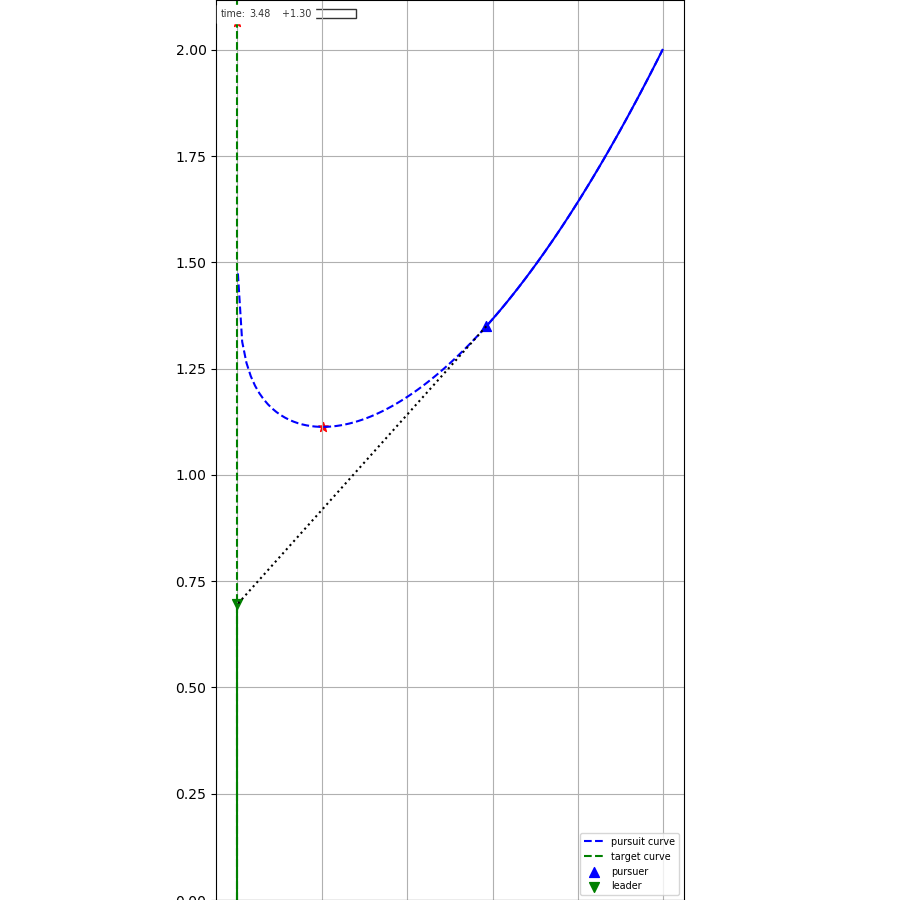

In [10]:
syst = StraightLinePursuit(q=.9,v=.2); ini = dict(x=1.,y=2.)
#syst = StraightLinePursuit(q=-.9,v=1.); ini = dict(x=1.,y=2.) # dual of previous one
#syst = StraightLinePursuit(q=1.1,v=.2); ini = dict(x=1.,y=2.)
syst.launch(ini=syst.makestate(**ini))

### Semi-analytic solution when the target is a circle

We assume the origin of the referential frame is taken to be the centre of the target circle (of radius $\hat{R}$), and the horizontal axis to be the diameter of the circle going through point $\hat{A}$. The natural parametrisation of the target is hence given by
\begin{equation*}
\hat{x}(s) = \hat{R}\cos(\frac{s}{\hat{R}}) \hspace{2cm} \hat{y}(s) = \hat{R}\sin(\frac{s}{\hat{R}})
\end{equation*}
There is no obvious analytic parametrisation of the pursuit curve, but the equations can be transformed into the following ODE with a single variable $\phi$ and parameter $u$:
\begin{eqnarray*}
\phi' & = & \frac{q}{\frac{\sin^2(u)}{\sin(\phi)}+(q-\frac{\sin^2(u)}{\sin(\phi)})\frac{\tan(u)}{\tan(\phi)}}\\
\phi(u_o) & = & \theta_o+u_o \hspace{.5cm}\textrm{where}\hspace{.5cm} u_o=\arctan\left(\frac{\sin(\theta_o)}{\frac{r_o}{\hat{R}}-\cos(\theta_o)}\right)
\end{eqnarray*}
The other variables (in polar coordinates) are obtained by
\begin{equation*}
r = \hat{R}\frac{\sin(\phi)}{\sin(u)}
\hspace{2cm}
\theta' = \frac{\phi'-1}{1-q\frac{\sin(\phi)}{\sin^2(u)}}
\hspace{2cm}
\frac{q\ell}{\hat{R}} = \theta+u-\phi
\end{equation*}
or alternatively
\begin{equation*}
r = \hat{R}\frac{\sin(\phi)}{\sin(u)}
\hspace{2cm}
\frac{q\ell'}{\hat{R}} = \phi'(\frac{\tan(u)}{\tan(\phi)}-1)
\hspace{2cm}
\theta = \frac{q\ell}{\hat{R}}-u+\phi
\end{equation*}
Cartesian coordinates can of course be recovered by
\begin{equation*}
x = r\cos(\theta)
\hspace{2cm}
y = r\sin(\theta)
\end{equation*}
An empirical analysis indicates that, apart from singular cases:
* when $q<1$ the pursuit curve touches the target circle at a point where they have a common tangeant
* when $q>=1$ the pursuit curve asymptotically converges toward a circle with same centre as the target circle and of radius $\frac{\hat{R}}{q}$

In both cases, the pursuit curve may also intersect the target circle, but at points where the tangeants are distinct.

The program below augments the basic simulation by drawing, before the start of the simulation, a segment of the predicted pursuit curve, as well as its asymptotic circle when $q\geq1$. Note however that since that prediction is itself obtained by a numerical method, it is not so different from the simulation.

In [13]:
class CircularPursuit (Pursuit):

  @Setup(
    Pursuit.__init__,
    'ω: angular speed of leader [rd.sec^-1]',
    'R: radius of leader\'s circular trajectory [m]',
    'variant: either \'theta\' or \'Kell\' specifying which variable is solved by integration in the primary ODE',
    'safe: whether to keep primary ODE within safe zone',
    ω=1.0,R=1.,variant='Kell',safe=False
  )
  def __init__(self,ω,R,variant,safe,du=.001,**ka):
    super().__init__(F=(lambda t,pos,ω=ω: ω*array((-pos[1],pos[0]))),**ka)
    self.R = R; self.variant = variant; self.du = du; self.safe = safe

  def analytics(self,state):
    from scipy.integrate import ode
    def F(u,φ_s):
      φ,s = φ_s
      dφ = q*sin(φ)/(square(sin(u))+tan(u)*(q*cos(φ)-square(sin(u))/tan(φ)))
      ds = varF(u,φ,dφ)
      return array((dφ,ds))
    def varFtheta(u,φ,dφ): return (dφ-1)/(1-q*sin(φ)/square(sin(u)))
    def varFKell(u,φ,dφ): return dφ*(tan(u)/tan(φ)-1)
    def run(direc,du=self.du):
      r = ode(F).set_integrator('lsoda').set_initial_value((φₒ,sₒ),uₒ)
      dt = direc*du
      while r.successful():
        yield r.t,r.y
        if self.safe and abs(r.t+dt)>pi/2: break
        r.integrate(r.t+dt)
    x,y = state[0:2]
    r = norm((x,y))
    θ = arctan2(y,x)
    x_ = x-square(r)/self.R
    uₒ = -arctan(y/x_)
    φₒ = θ+uₒ
    q = self.q*sign(x_)
    varF,sₒ = dict(theta=(varFtheta,θ),Kell=(varFKell,0.))[self.variant]
    L = list(run(-1.)); n = len(L); del L[0]
    L.reverse(); L.extend(run(1.))
    Lu,Lφ,Ls = array(list((u,φ,s) for u,(φ,s) in L)).T
    Lr = self.R*sin(Lφ)/sin(Lu)
    Lθ,Lkℓ = dict(theta=(Ls,Ls+Lu-Lφ),Kell=(Ls-Lu+Lφ,Ls))[self.variant]
    if n == len(L): n -= 1
    return n,Lu,Lφ,Lr,Lθ,Lkℓ

  def display(self,ax,ini=None,**ka):
    from matplotlib.patches import Circle
    n,Lu,Lφ,Lr,Lθ,Lkℓ = self.analytics(ini)
    Lx,Ly = Lr*cos(Lθ),Lr*sin(Lθ)
    nstar = argmin(norm((Lx-self.R*cos(Lkℓ),Ly-self.R*sin(Lkℓ))))
    ax.plot(Lx,Ly,c='b',ls='--',label='pursuit curve')
    ax.scatter((Lx[nstar],),(Ly[nstar],),marker='*',color='r',s=50)
    ax.add_patch(Circle((0.,0.),self.R,ec='g',fc='none',ls='--',label='target curve'))
    if abs(self.q)>=1: ax.add_patch(Circle((0.,0.),self.R/abs(self.q),ec='b',fc='none',ls='--'))
    for i in 0,-1: ax.annotate(r'${:.1f}\frac{{\pi}}{{2}}$'.format(Lu[i]*2/pi),(Lx[i],Ly[i]),fontsize='x-small',zorder=1)
    ax.scatter((Lx[0],Lx[-1]),(Ly[0],Ly[-1]),marker='.',color='r')
    return super().display(ax,ini=ini,**ka)

  @staticmethod
  @Setup(
    'x,y: position of the pursuer (leader is in 1,0)',
  )
  def makestate(x,y): return array((x,y,1.,0.))

In [14]:
Setup.display(CircularPursuit)

**** CircularPursuit.__init__(self, ω, R, variant, safe, du=0.001, **ka) ****
    q         : ratio of leader's speed to pursuer's speed []
    tol       (0.001     ): threshold on the pursuer-leader distance, below which pursuit is stopped []
    ω         (1.0       ): angular speed of leader [rd.sec^-1]
    R         (1.0       ): radius of leader's circular trajectory [m]
    variant   ('Kell'    ): either 'theta' or 'Kell' specifying which variable is solved by integration in the primary ODE []
    safe      (False     ): whether to keep primary ODE within safe zone []
**** Pursuit.launch(self, *a, **ka) ****
    maxtime   (inf       ): total simulation time length [sec]
    srate     (25.0      ): sampling rate [sec^-1]
    taild     (10.0      ): shadow duration [sec]
    hooks     ((functools): tuple of display hooks []
    ini       : initial state []
**** CircularPursuit.makestate(x, y) ****
    x,y       : position of the pursuer (leader is in 1,0) []

<IPython.core.display.Javascript object>


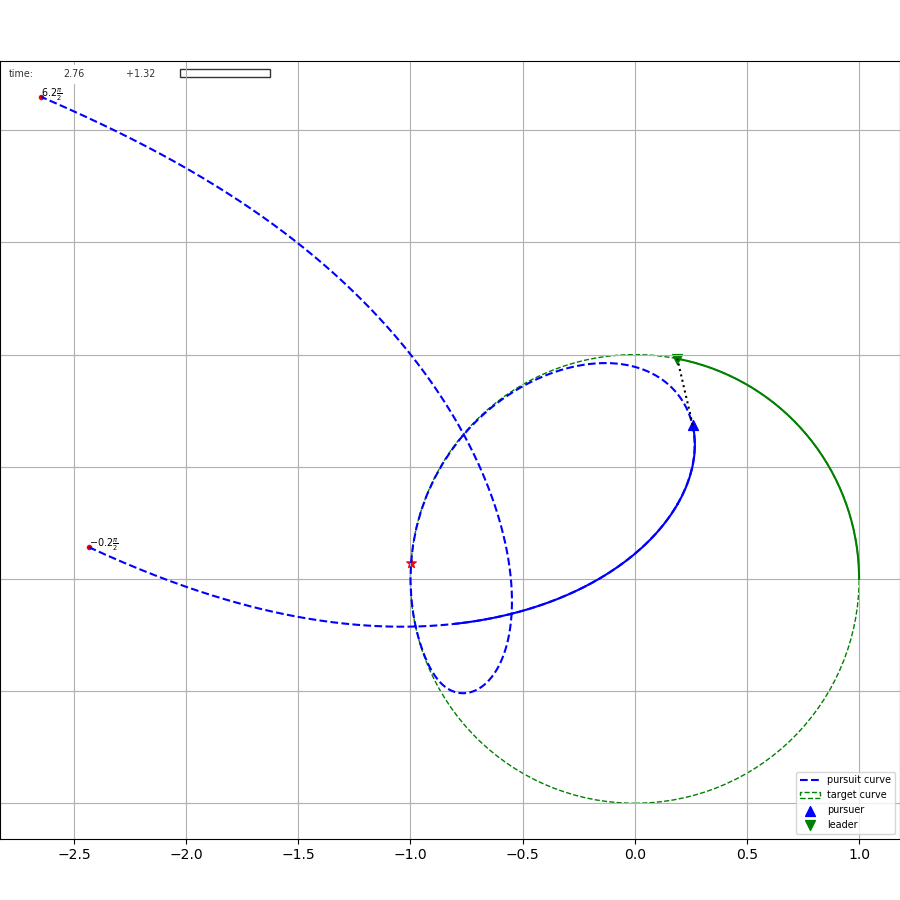

In [16]:
syst = CircularPursuit(q=.9,ω=.5); ini = dict(x=-.8,y=-.2)
#syst = CircularPursuit(q=-.9,ω=.5); ini = dict(x=-.8,y=-.2) # dual of previous
#syst = CircularPursuit(q=.5,ω=.1); ini = dict(x=.5,y=-.1)
#syst = CircularPursuit(q=.5,ω=.05); ini = dict(x=-.2,y=.4)
#syst = CircularPursuit(q=-1.3,ω=.1); ini = dict(x=.3,y=.5)
#syst = CircularPursuit(q=1.3,ω=1.); ini = dict(x=-3.,y=-1.)
syst.launch(ini=syst.makestate(**ini))